# Семинар 2. Введение в NumPy

## Мотивация к изучению

Во многих прикладных задачах вам предстоит иметь дело с данными, хранящимися в массивах различной размерности. Так, например, при работе с радиолокационными или акустическими сигналами вы, скорее всего, будете иметь дело с одномерными массивами, ячейки которых будут представлять собой дескритизированное время, а содержимое этих ячеек - амплитуду сигнала. При анализе одноканальных изображений вам предстоит обрабатывать двумерные массивы, в ячейках которых закодированы яркости пикселей изображения. Наконец, при работе с цветными изображениями вы столкнетесь с многомерными массивами - тензорами. Также многомерные массивы лежат в основе большого количества алгоритмов и технологий, к числу которых относятся, например, сверточные нейронные сети.

![image-struct](./images/image_struct.png)

Из всего выше сказанного, очевидно, что необходим инструмент для работы с большими массивами и массивами большой размерности. Из заголовка семинара и из хода повествования вам должно быть очевидно, что к числу таких инструментов и относится `NumPy`. Однако, прежде, чем перейти к знакомству с ним, давайте подумаем, почему мы не можем использовать "чистый" Python для работы с большими и многомерными массивами. Решим пару задач.

## Задача 1. Перегруз

**Познавательная минутка**

Думаю, все вы слышали звук перегруженной гитары (если это не так, могу вам только посочувствовать и посоветовать послушать *Black Sabbath - "Iron Man"*). Давайте разберемся откуда берется этот звук, на примере перегруженного усилителя. Итак, в нашем распоряжении есть электрогитара и гитарный усилитель. С помощью электрогитары мы получаем некоторый электромагнитный сигнал, который поступает на вход усилителя по кабелю. Внутри гитарного усилителя происходит, как это не странно, усиление входного сигнала. Усиленный сигнал поступает на динамик усилителя, и мы слышим музыку. Однако амплитудный диапазон динамика не резиновый, и он не может воспроизводить любой училенный сигнал в исходном виде и без искажений. Когда амплитуда усиленного сигнала превышает максимальную амлитуду, которую способен воспроизвести динамик, происходит так называемый клиппинг, т.е. обрезание пиков. В результате мы слышим искаженный усиленный сигнал и получаем тот самый эффект перегруза.

![signal-clipping](./images/clipping.png)

**Задание**

Для того, чтобы понять, почему "чистый" Python не подойдет для работы с большими массивами, реализуем описанный выше алгоритм клиппинга. Чтобы реализовать алгоритм, нам потребуется:
- Создать сам сигнал;
- Усилить сигнал;
- Клипнуть сигнал;

Для каждого описанного выше шага реализуем функцию отдельную функцию.

Функция для создания сигнала будет принимать на вход период дискретизации (шаг по времени), количество дискретов (число отсчетов в сигнале), функцию модуляции - $f(x)$. Выходным значением будет список, элементами которого являются значения функции $sin(t_i) * f(t_i)$.

Функция усиления сигнала будет принимать на вход список действительных числе - входной сигнал, - и целое число - коэффициент усиления. Выходом функции будет список, элементы которого - элементы исходного списка, умноженные на коэффициент усиления.

Функия клиппинга будет принимать на вход усиленный сигнал порог, по которому будет производиться обрезание. Выход функции - список, элементы которого - клипнутые элементы входного массива.

**Необходимые импорты:**

In [1]:
import math
import sys
import os

from typing import Sequence, Callable, Optional

from utils import read_floats_from_bytes
from utils import visualize_1d_array

**Константы:**

In [2]:
sequence_size = int(1e7)                    # количество отсчетов в сигнале                          
time_step = 6 * math.pi *1e-7               # период дискретизации
amplification = 10                          # коэффициент усиления
thrashold = 4                               # порог
modulation = lambda x: math.exp(-0.1 * x)   # функция модуляции
eps = 1e-6                                  # точность

**Функции:**

In [15]:
def get_signal(
    sequence_size: int,
    time_step: float,
    modulation: Optional[Callable[[float], float]] = None,
) -> list[float]:
    if modulation:
        return [
            modulation(time_step * i) * math.sin(time_step * i)
            for i in range(sequence_size)
        ]
    else:
        return [math.sin(time_step * i) for i in range(sequence_size)]

In [16]:
def amplify_signal(
    signal: Sequence[float],
    amplification: float,
) -> Sequence[float]:

    return [i * amplification for i in signal]

In [29]:
def apply_clipping(
    signal: Sequence[float],
    thrashold: int,
) -> Sequence[float]:
    signal_new = []
    
    for element in signal:
        if element > thrashold and element > 0:
            signal_new.append(thrashold)
        elif abs(element) > thrashold and element < 0:
            signal_new.append(-thrashold)
        else:
            signal_new.append(element)

    return signal_new

**Тесты:**

In [30]:
signal = get_signal(sequence_size, time_step, modulation)
signal_amplified = amplify_signal(signal, amplification)
signal_clipped = apply_clipping(signal_amplified, thrashold)

print(f"signal size: {sys.getsizeof(signal)} bytes")

signal size: 89095160 bytes


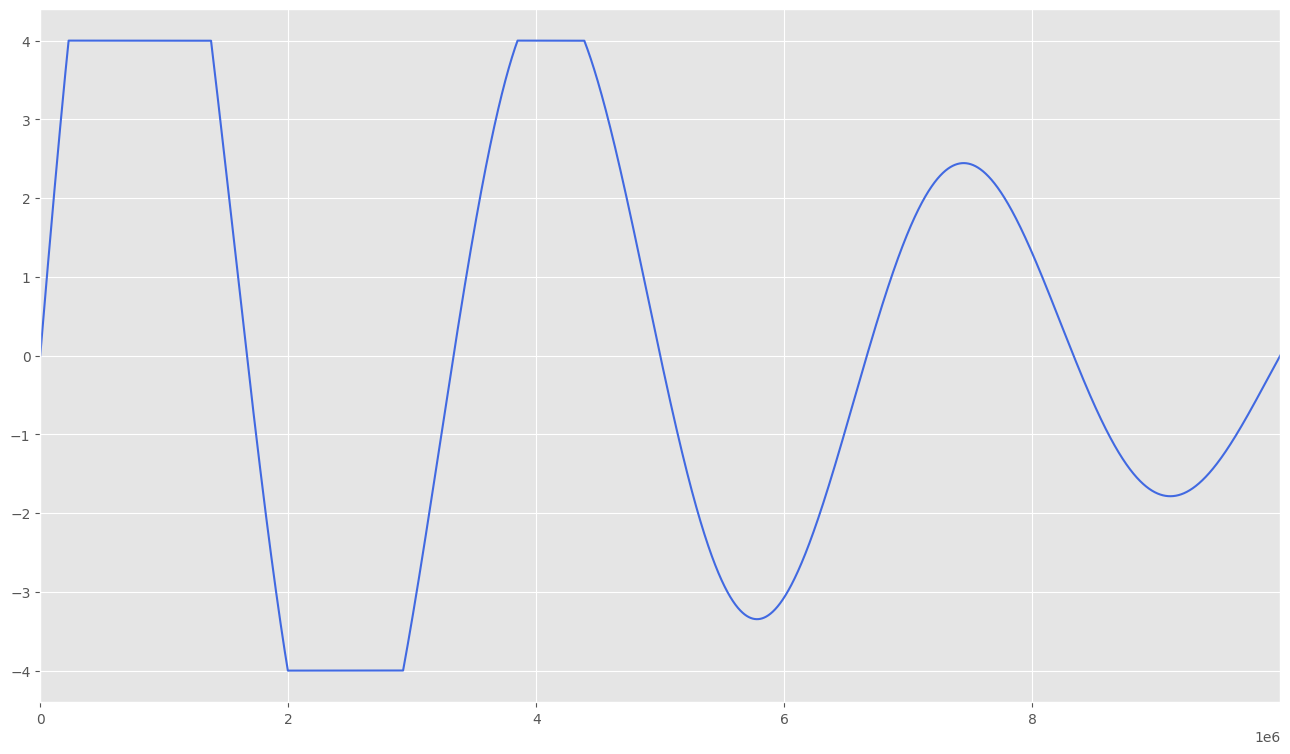

In [31]:
visualize_1d_array(ordinate=signal_clipped)

In [32]:
assert signal is not signal_amplified
assert signal_amplified is not signal_clipped

In [33]:
path_to_reference = os.path.join("test_data", "signal_clipped.log")
assert os.path.exists(path_to_reference)

signal_referense = read_floats_from_bytes(
    sequence_size, path_to_reference
)

assert all(
    abs(amp - amp_ref) < eps
    for amp, amp_ref in zip(signal_clipped, signal_referense)
)

In [34]:
del signal
del signal_amplified
del signal_clipped
del signal_referense

Как можно видеть, уже на 10 миллионах чисел с плавающей точкой у нас начинаются проблемы. Клиппинг происходит достаточно медленно. Может, дела обстоят иначе для многомерных массивах?

## Задача 2. Матрицы

### Часть 1. Перемножение

Задача проста: необходимо реализовать функцию, которая занималась бы перемножением двух матриц по всем правилам линейной алгебры. На вход подаются два двумерных массива чисел с плавающей точкой, на выходе мы должны получить двумерный массива чисел с плавающей точкой - произведение входных матриц. 

Также функция должна уметь проверять размеры входных массивов и возбуждать исключение, в случае, если размеры матриц не позволяют вычислить произведение. Предполагаем, что на вход всегда подаются двумерные массивы, даже в случае векторов.

**Необходимые импорты:**

In [24]:
from random import randint
from numbers import Real

**Константы:**

In [22]:
columns_amount = 1000           # число колонок в матрице
rows_amount = 500               # число строк в матрице

bottom = -10                    # нижняя граница значений числе в матрице
top = 10                        # верхняя граница значений числе в матрице

**Функции:**

In [3]:
def multiply_matrices(
    lhs: list[list[Real]],
    rhs: list[list[Real]],
) -> list[list[Real]]:
    if len(lhs[0]) != len(rhs):
        raise ValueError("invalid matrices sizes")
    
    

    return [[0]]

**Тесты:**

In [19]:
lhs = [
    [7, -1, -4],
    [-1, 5, -1],
]
rhs = [
    [-2, -5],
    [-5, -6],
    [-5, 3],
]
reference = [
    [11, -41],
    [-18, -28]
]

In [21]:
result = multiply_matrices(lhs, rhs)

assert all(
    all(
        num_res == num_ref 
        for num_res, num_ref in zip(row_res, row_ref)
    )
    for row_res, row_ref in zip(result, reference)
)

was_raised = False

try:
    result = multiply_matrices(lhs, rhs[:2])

except ValueError:
    was_raised = True

assert was_raised

In [23]:
lhs = [
    [randint(bottom, top) for _ in range(columns_amount)]
    for _ in range(rows_amount)
]

rhs = [
    [randint(bottom, top) for _ in range(rows_amount)]
    for _ in range(columns_amount)
]

result = multiply_matrices(lhs, rhs)

In [ ]:
del lhs
del rhs
del result

### Часть 2. Транспонирование

Транспонируйте матрицу. На вход подается двумерный массив, выход: транспонированный двумерный массив.

**Необходимые импорты:**

In [26]:
from numbers import Real

**Функции:**

In [27]:
def transpose(matrix: list[list[Real]]) -> list[list[Real]]:
    # ваш код

    return matrix

**Тесты:**

In [31]:
matrix = [
    [-2, -5],
    [-5, -6],
    [-5, 3],
]
reference = [
    [-2, -5, -5],
    [-5, -6, 3],
]

In [33]:
transposed = transpose(matrix)

assert transposed is not matrix
assert all(
    all(
        num_res == num_ref 
        for num_res, num_ref in zip(row_res, row_ref)
    )
    for row_res, row_ref in zip(transposed, reference)
)

In [39]:
size = int(2e3)

matrix = [
    [randint(bottom, top) for _ in range(size)]
    for _ in range(size)
]

transposed = transpose(matrix)

In [ ]:
del transposed

Как видите с многомерными массивами "чистый" Python работает достаточно медленно. Тут-то на сцену и выходит `NumPy`.


## Что такое NumPy?

Прежде чем перейти к самому NumPy, давайте разберемся, почему работа с большими массивами данных средствами Python настолько неэффективна. Ключ к пониманию кроется в способе хранения данных в Python. Напомню, что любой объект в CPython - это не просто ячейка памяти со значением, как это было в C или C++. Объект в CPython - это указатель на структуру C. В этой структуре, помимо самого значения объекта хранятся метаданыые объекта, которые используются интерпретатором Python. К числу таких данных относится тип объекта, счетчик ссылок, размер объекта. Массивы же - это не просто указатели на непрерывный блок памяти с необходимыми данными, которые можно было бы быстро обрабатывать за счет кеширования. Массивы в CPython - это непрерывные области памяти, в которых хранятся адреса объектов CPython в памяти. Таким образом при обработке массива, мы читаем из памяти два раза: сначала адрес объекта, а потом сам объект. При этом указатели могут указывать на произвольные области памяти, которые не получится эффективно кешировать. Такой способ хранения данных с одной стороны позволяет иметь коллекции объектов различных типов данных, но с другой стороны сильно снижает эффективность обработки этих данных. 

NumPy подходит иначе к хранению данных. `NumPy` (сокращение от *Numerical Python*) - библиотека для эффективной работы с плотными массивами однородных данных. Особенно стоит выделить слово "однородными", ведь именно оно позволяет понять причину эффективности NumPy. Массивы NumPy являются оберткой вокруг C-массивов, т.е. массив NumPy инкапсулирует указатель на непрерывный блок в памяти, в котором хранятся данные одного типа. Это сильно ускоряет работу с этими данными и даже позволяет сэкономить память.

![arrays](./images/arrays.png)

## Быстрая демонстрация возможностей

Чтобы убедиться, что эффективность NumPy - это не пустое преувеличение, реализуем решение всех поставленных выше задач с помощью NumPy.

In [40]:
import numpy as np

from utils import visualize_1d_array

### Перегруз

In [41]:
sequence_size = int(1e7)                    # количество отсчетов в сигнале                          
amplification = 10                          # коэффициент усиления
thrashold = 4                               # порог
eps = 1e-6                                  # точность

In [42]:
time = np.linspace(0, 6 * np.pi, sequence_size)

signal = np.sin(time) * np.exp(-0.1 * time)
signal_amplified = amplification * signal

signal_clipped = signal_amplified.copy()
mask = np.abs(signal_clipped) > thrashold
signal_clipped[mask] = np.sign(signal_clipped[mask]) * thrashold

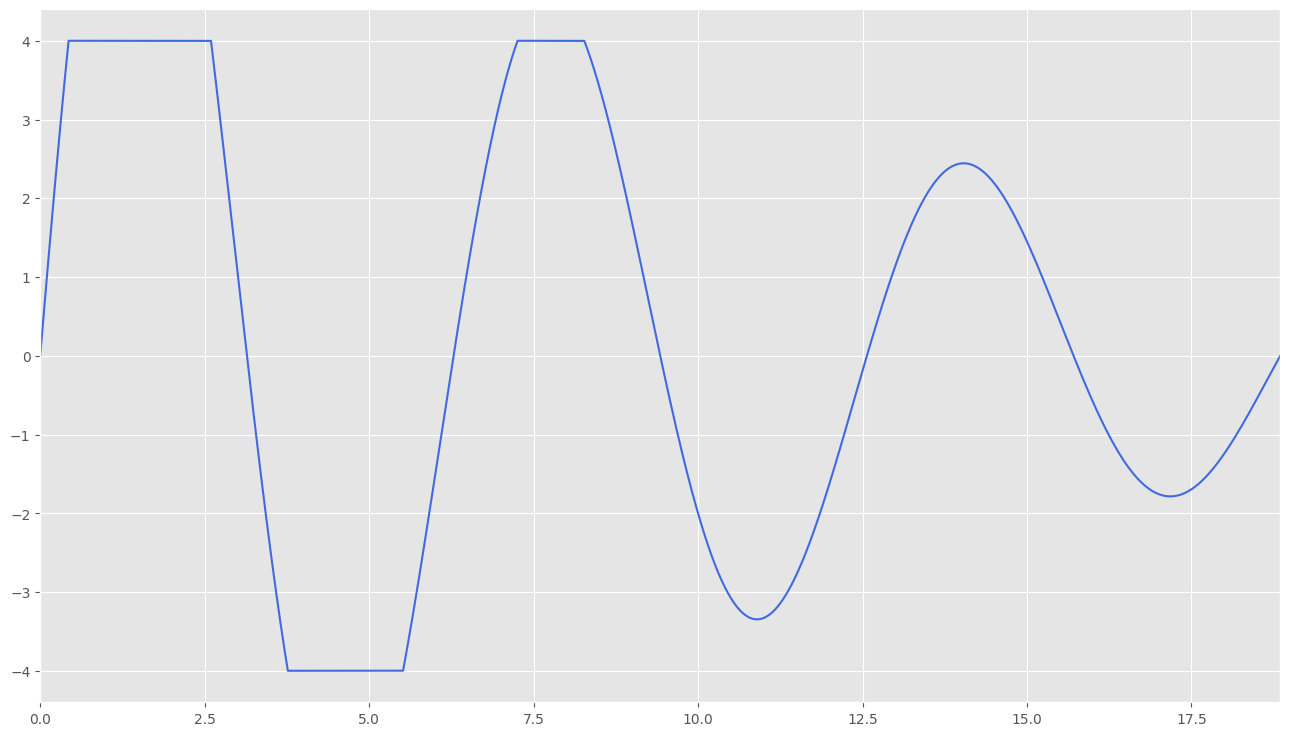

In [43]:
visualize_1d_array(abscissa=time, ordinate=signal_clipped)

In [ ]:
del signal
del signal_amplified
del signal_clipped

### Перемножение матриц

In [5]:
columns_amount = 1000           # число колонок в матрице
rows_amount = 500               # число строк в матрице

bottom = -10                    # нижняя граница значений числе в матрице
top = 10                        # верхняя граница значений числе в матрице

In [6]:
lhs = np.random.randint(
    low=bottom,
    high=top,
    size=(rows_amount, columns_amount),
)
rhs = np.random.randint(
    low=bottom,
    high=top,
    size=(columns_amount, rows_amount),
)

result = lhs @ rhs
result

array([[  752,  -723,  -367, ...,  -337,   699,    57],
       [ -614,  -932,   644, ...,   396,   598, -2003],
       [  345,   -25,  -379, ...,  -695, -1651,   -61],
       ...,
       [  549,  -399,  -893, ..., -1599,  1341,   891],
       [-1167,  -117,    22, ...,  1202, -1328,   392],
       [-1226,  2363,   434, ...,   678,  -911, -1123]])

In [7]:
del lhs
del rhs
del result

### Транспонирование

In [8]:
size = int(1e6)

matrix = np.random.randint(
    low=bottom,
    high=top,
    size=(rows_amount, columns_amount),
)

transposed = matrix.T
del transposed

Как вы видите NumPy позволяет решать задачи с матричными вычислениями на порядки быстрее.

## Основы NumPy

### Создание массивов

Как вы поняли из всего сказанного выше, центральным элементов фреймворка является многомерный массив. Именно поэтому мы начнем знакомство с создания массивов. Обычный и самый распространненный способ создания массива - функция `array()`, которая принимает на вход массиво-подобные объекты и возвращает массив NumPy.

#### Создание массивов из объектов Python

In [9]:
array_python = list(range(5))

array_ints = np.array(array_python)
print(f"{array_ints = }")

array_python[3] = 3.14

array_floats = np.array(array_python)
print(f"{array_floats = }")

array_python[3] = 3

array_doubles = np.array(array_python, dtype=np.float64)
print(f"{array_doubles = }")

array_of_objects = [
    1, 2.27, [1, 2, 3], {"a": 1, "b": 2}
]
array_of_objects = np.array(array_of_objects, dtype=object)
print(f"{array_of_objects = }")

array_2d = np.array(
    [[i + j for j in range(5)] for i in range(5)]
)
print(array_2d)

array_ints = array([0, 1, 2, 3, 4])
array_floats = array([0.  , 1.  , 2.  , 3.14, 4.  ])
array_doubles = array([0., 1., 2., 3., 4.])
array_of_objects = array([1, 2.27, list([1, 2, 3]), {'a': 1, 'b': 2}], dtype=object)
[[0 1 2 3 4]
 [1 2 3 4 5]
 [2 3 4 5 6]
 [3 4 5 6 7]
 [4 5 6 7 8]]


Массив NumPy содержит данные одного типа. При попытке создания массива из разнородных данных NumPy, если это возможно, будет производить повышающее приведение типов до тех пор, пока все данные не будут унифицированы. 

Так во втором примере, из-за наличия в данных числа 3.14, итоговый тип данных массива - float. В четвертом примере NumPy не сможет самостоятельно привести данные к одному типу, поэтому нам пришлось указать их явно. Тип object наиболее общий и означает, что массив состоит из объектов языка Python (в нашем примере int, float, list и dict).

При необходимости можно явно указать желаемый тип данных, путем присвоение атрибуту `dtype` допустимого значения. 

Также обратите внимание на последний пример. В NumPy возможно создание многомерных массивов из списков со вложенными списками. Однако для этого требуется, чтобы вложенные списки имели одинаковый рамер. Так в нашем примере вложенные списки интерпретируются, как строки двухмерной матрицы.

#### Создание массивов "с нуля"

Мы не всегда имеем под рукой объект, который бы хотелось представить в виде многомерного массива NumPy. Иногда целесообразней, или даже необходимо, создать новый объект "с нуля". Для этих целей в NumPy есть ряд функций.

**zeros/ones/full:**

Это набор функций, которые позволяют создавать массивы, заполненные одинаковыми элементами. Так функция `zeros` позволяет создать массив, заполненный нулями, `ones` - массив, заполненный единицами, а `full` - массив, заполненный переданными значением. Поэтому сигнатуры функций очень похожи между собой.

In [10]:
zeros_1d = np.zeros(shape=10, dtype=np.uint8)
ones_1d = np.ones(shape=5, dtype=np.uint32)

zeros_3d = np.zeros(shape=(3, 3, 3), dtype=np.float32)
full_2d = np.full(shape=(5, 5), fill_value=255, dtype=np.uint8)

print(f"Zeros 1D:\n{zeros_1d}", end="\n\n")
print(f"Zeros 3D:\n{zeros_3d}", end="\n\n")
print(f"Ones 1D:\n{ones_1d}", end="\n\n")
print(f"Full 2D:\n{full_2d}")

Zeros 1D:
[0 0 0 0 0 0 0 0 0 0]

Zeros 3D:
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]

Ones 1D:
[1 1 1 1 1]

Full 2D:
[[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]]


Эти функции могут быть полезными при создании некоторых заготовок или аккумуляторов для вычислений.

**linspace:**

В задаче на вычисление перегруза для генерации сигнала нам потребовалось вычислять значение времени, зная шаг дискретизации. Однако нам не всегда может быть известен шаг дискретизации, но может быть известен диапазон значений и количество отсчетов, которые необходимо взять из данного диапазона. Поскольку такая задача является типовой и встрачается на практике очень часто, в NumPy реализована специальная функция для этого:

In [11]:
np.linspace(0, np.pi, 32)

array([0.        , 0.1013417 , 0.2026834 , 0.3040251 , 0.40536679,
       0.50670849, 0.60805019, 0.70939189, 0.81073359, 0.91207529,
       1.01341699, 1.11475868, 1.21610038, 1.31744208, 1.41878378,
       1.52012548, 1.62146718, 1.72280887, 1.82415057, 1.92549227,
       2.02683397, 2.12817567, 2.22951737, 2.33085907, 2.43220076,
       2.53354246, 2.63488416, 2.73622586, 2.83756756, 2.93890926,
       3.04025096, 3.14159265])

**Немного о random:**

В ряде задач бывает полезно создать массивы, заполненые слычайными числами из определенного распределения вероятностей. Так, например, в глубоком обучении для повышения качества модели с функцией активации ReLU рекомендуется инициализировать веса случайными числами из нормального закона распределения.

Эту задачу можно решить используя подмодуль NumPy, который носит характерное название `random`.

In [12]:
normal = np.random.normal(loc=0, scale=1, size=(3, 3))
uniform = np.random.uniform(low=-10, high=10, size=(3, 3))
randomint = np.random.randint(0, 10, size=(3, 3))

print(f"Normal:\n{normal}", end="\n\n")
print(f"Uniform:\n{uniform}", end="\n\n")
print(f"Randint:\n{randomint}", end="\n\n")

Normal:
[[ 1.53003912 -0.34450547  0.15121661]
 [ 0.73746351 -0.09690138  0.94998894]
 [-0.44153561 -0.71347091 -0.20661139]]

Uniform:
[[-0.41051402  4.08629485 -6.07134344]
 [-9.57050321 -3.1800736   7.53383992]
 [-9.87090971 -5.46004201 -8.60773062]]

Randint:
[[8 8 2]
 [0 3 7]
 [5 2 4]]



**eye/diag**

Поскольку NumPy часто используется для реализации вычислений из линейной алгебры, о чем мы поговорим в будущем, в нем есть отдельные функции для создания единичных матриц и диагональных матриц.

In [13]:
eye_square = np.eye(5)
eye_rectangle = np.eye(3, 5)
diag = np.diag([3, 5, 9])

print(f"Eye Square:\n{eye_square}", end="\n\n")
print(f"Eye Rectangle:\n{eye_rectangle}", end="\n\n")
print(f"Diagonal:\n{diag}", end="\n\n")

Eye Square:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]

Eye Rectangle:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]

Diagonal:
[[3 0 0]
 [0 5 0]
 [0 0 9]]



**empty:**

В ряде задач полезно создать "пустой" массив, т.е. массив, который не инициализирован никакими данным. Этот массив может быть использован в качестве буффера, в который будут записываться результаты различных матричных операций.

In [15]:
np.empty(5)

array([1., 1., 1., 1., 1.])

### Атрибуты массивов

In [16]:
def print_attributes(array: np.ndarray) -> None:
    print('\n--------------------------------------------------')
    print(f'\n{array}\n')
    print(f'Array shape: {array.shape};')
    print(f'Array dimension: {array.ndim};')
    print(f"Array element's amount: {array.size};")
    print(f"Array element's size: {array.itemsize}")
    print(f'Array memory space: {array.nbytes};')
    print('--------------------------------------------------')

In [17]:
arrays = [np.random.uniform(0, 10, size=3),
          np.random.uniform(0, 10, size=(3, 3)),
          np.random.uniform(0, 10, size=(3, 3, 3))]

for array in arrays:
    print_attributes(array)


--------------------------------------------------

[3.10367194 5.86588752 3.6409313 ]

Array shape: (3,);
Array dimension: 1;
Array element's amount: 3;
Array element's size: 8
Array memory space: 24;
--------------------------------------------------

--------------------------------------------------

[[0.31300149 7.52663135 0.31598594]
 [9.31106233 3.03650624 3.54366624]
 [8.49255503 4.71749977 9.43427696]]

Array shape: (3, 3);
Array dimension: 2;
Array element's amount: 9;
Array element's size: 8
Array memory space: 72;
--------------------------------------------------

--------------------------------------------------

[[[5.7316334  8.79336983 3.58292233]
  [2.27976174 2.92382128 4.38984489]
  [9.86085608 9.66242165 3.23546889]]

 [[5.53527911 9.89999877 6.33308974]
  [4.75059402 0.97214235 4.17429641]
  [6.74424511 2.30312814 3.45776777]]

 [[2.0661647  3.20929115 8.08124787]
  [3.08400917 4.45686812 0.01476728]
  [3.62729491 7.02985026 3.24045378]]]

Array shape: (3, 3, 3);

### Доступ к элементам

In [18]:
arr_1d, arr_2d, arr_3d = arrays

#### Индексация

Индексация массивов в NumPy представляет собой улучшенную индексацию списков в Python. Сами по себе массивы NumPy - изменяемый тип данных, т.е. мы можем перезаписывать элементы с помощью индексации.

In [20]:
line_len, fill_val = 80, "-"

print("Python Way".center(line_len, fill_val))
print(f"1D:\n{arr_1d[0]}")
print(f"2D:\n{arr_2d[0][2]}")
print(f"3D:\n{arr_3d[0][1][2]}", end="\n\n")

print("NumPy Way".center(line_len, fill_val))
print(f"2D:\n{arr_2d[0, 2]}")
print(f"3D:\n{arr_3d[0, 1, 2]}")

-----------------------------------Python Way-----------------------------------
1D:
3.10367193610999
2D:
0.31598594433415617
3D:
4.389844892896884

-----------------------------------NumPy Way------------------------------------
2D:
0.31598594433415617
3D:
4.389844892896884


#### Срезы

В одномерном случае срезы так же аналогичны срезам списков в Python.

In [21]:
numbers = np.arange(20)

print(numbers)
print(numbers[5: 10])
print(numbers[::2])
print(numbers[1::2])
print(numbers[::-1])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[5 6 7 8 9]
[ 0  2  4  6  8 10 12 14 16 18]
[ 1  3  5  7  9 11 13 15 17 19]
[19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]


Однако, помимо знакомых нам одномерных срезов, в NumPy есть крайне удобные многомерные срезы:

In [23]:
print(arr_2d, end="\n\n")

arr_2d[1:, 1:] = 100
print(arr_2d, end="\n\n")
print(arr_2d[::2, ::2], end="\n\n")
print(arr_2d[::-1, 0], end="\n\n")

[[  0.31300149   7.52663135   0.31598594]
 [  9.31106233 100.         100.        ]
 [  8.49255503 100.         100.        ]]

[[  0.31300149   7.52663135   0.31598594]
 [  9.31106233 100.         100.        ]
 [  8.49255503 100.         100.        ]]

[[  0.31300149   0.31598594]
 [  8.49255503 100.        ]]

[8.49255503 9.31106233 0.31300149]



Важное замечание, которое стоит держать в голове: в отличие от списков в Python, срезы массивов в NumPy возвращают не новый объект, а указатель на область существующего объекта. Т.е. записав результат среза в новую переменную, у вас есть возможность безвозвратно изменить исходный объект, совершая манипуляции с этой новой переменной. Проиллюстрируем эти утверждения следующим примером:

In [27]:
numbers = np.arange(10)

print(numbers, end="\n\n")

my_slice = numbers[5: 10]
my_slice[:] = 100

print(my_slice, end="\n\n")
print(numbers, end="\n\n")

[0 1 2 3 4 5 6 7 8 9]

[100 100 100 100 100]

[  0   1   2   3   4 100 100 100 100 100]



Чтобы избежать подобного нежелательного поведения, используйте метод `copy()` при связывании срезов с различными переменными:

In [28]:
numbers = np.arange(10)

print(numbers, end="\n\n")

my_slice = numbers[5: 10].copy()
my_slice[:] = 100

print(my_slice, end="\n\n")
print(numbers, end="\n\n")

[0 1 2 3 4 5 6 7 8 9]

[100 100 100 100 100]

[0 1 2 3 4 5 6 7 8 9]



#### Индексация массивами

Помимо срезов и простых индексов, вы можете за раз выбрать сразу несколько элементов, используя массивы в качестве индексов.

In [38]:
data_1d = np.random.randint(0, 10, size=15)
data_2d = data_1d.reshape(5, 3)

print(f"Data 1D:\n{data_1d}", end="\n\n")
print(f"Data 2D:\n{data_2d}", end="\n\n")

indices_1d = [2, 7, 13, 8]
indices_2d = [0, 1, 2], [0, 1, 2]

print(f"Index 1D:\n{data_1d[indices_1d]}", end="\n\n")
print(f"Index 2D:\n{data_2d[indices_2d]}", end="\n\n")

Data 1D:
[1 1 7 4 7 3 1 9 6 7 7 8 4 5 1]

Data 2D:
[[1 1 7]
 [4 7 3]
 [1 9 6]
 [7 7 8]
 [4 5 1]]

Index 1D:
[7 9 5 6]

Index 2D:
[1 7 6]



Ну и разумеется через такую индексацию вы тоже имеете возможность перезаписывать исходный массив.

Более того, помимо простых индексов, вы можете индексировать массив булевыми масками, т.е. массивами, той же формы, что и исходный массив, но заполненными значениями `True` и `False`. Значение `True` будет означать использование элемента в данной позиции в результате применения маски, `False` - нет.

In [41]:
mask_1d = np.random.randint(0, 2, size=data_1d.shape, dtype=bool)
mask_2d = mask_1d.reshape(5, 3)

print(f"Mask 1D:\n{mask_1d}", end="\n\n")
print(f"Mask 2D:\n{mask_2d}", end="\n\n")

print(f"Masked 1D:\n{data_1d[mask_1d]}", end="\n\n")
print(f"Masked 2D:\n{data_2d[mask_2d]}", end="\n\n")

Mask 1D:
[False False False False  True  True  True  True False False False  True
  True  True False]

Mask 2D:
[[False False False]
 [False  True  True]
 [ True  True False]
 [False False  True]
 [ True  True False]]

Masked 1D:
[7 3 1 9 8 4 5]

Masked 2D:
[7 3 1 9 8 4 5]



### Изменение размеров массива

Я ряде случаев бывает полезным изменить форму массива: буквально изменить размеры, или добавить новое измерение. В одном из следующих занятий мы поймем, зачем это нужно, а сейчас рассмотрим самые распространенные варианты для этих действий.

**reshape:**

Мы уже использовали этот метод в нескольких примерах выше. С его помощью можно получить новый массив заданной формы, элементами которого являются элементы исходного массива. Если заданный массив не может быть переведен в массив указанного размера, метод возбуждает исключение.

In [43]:
numbers = np.arange(15)
numbers_reshaped1 = numbers.reshape(5, 3)
numbers_reshaped2 = numbers.reshape(3, 5)

print(f"numbers:\n{numbers}", end="\n\n")
print(f"reshaped 1:\n{numbers_reshaped1}", end="\n\n")
print(f"reshaped 1:\n{numbers_reshaped2}")

numbers:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

reshaped 1:
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]]

reshaped 1:
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]


In [45]:
numbers.reshape(6, 2)

ValueError: cannot reshape array of size 15 into shape (6,2)

Также с помощью этого метода "вытянуть" исходный многомерный массив в одномерный.

In [46]:
print(numbers_reshaped1.reshape(-1))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


**flatten:**

Результат метода аналогичен результату метода `reshape(-1)`.

In [47]:
print(numbers_reshaped1.flatten())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


**transpose/T:**

Функция `transpose` позволяет транспонировать входной массив по правилам линейной алгебры. Возвращает новый массив, который можно безопасно изменять.

Атрибут массива `T`, когда это возможно, возвращает представление исходного массива, соответствующее транспонированию массива. Т.е. если связать возвращенное представление с новой переменной, то в вашей программе появится риск изменения исходных данных через эту переменную. Имейте это в виду и всегда думайте, что именно вы хотите получить: представление или копию.

In [4]:
array = np.random.randint(0, 10, size=(3, 4))

print(f"array:\n{array}", end="\n\n")
print(f"transpose:\n{np.transpose(array)}", end="\n\n")
print(f"T:\n{array.T}")

array:
[[0 8 5 9]
 [0 7 6 9]
 [8 3 8 2]]

transpose:
[[0 0 8]
 [8 7 3]
 [5 6 8]
 [9 9 2]]

T:
[[0 0 8]
 [8 7 3]
 [5 6 8]
 [9 9 2]]


**newaxis:**

Это специальная константа, которая позволяет удобно добавить новое измерения в ваш массив:

In [5]:
array = array.flatten()

print(f"array:\n{array}", end="\n\n")
print(f"array horizontal:\n{array[np.newaxis, :]}", end="\n\n")
print(f"array vertical:\n{array[:, np.newaxis]}", end="\n\n")

array:
[0 8 5 9 0 7 6 9 8 3 8 2]

array horizontal:
[[0 8 5 9 0 7 6 9 8 3 8 2]]

array vertical:
[[0]
 [8]
 [5]
 [9]
 [0]
 [7]
 [6]
 [9]
 [8]
 [3]
 [8]
 [2]]

